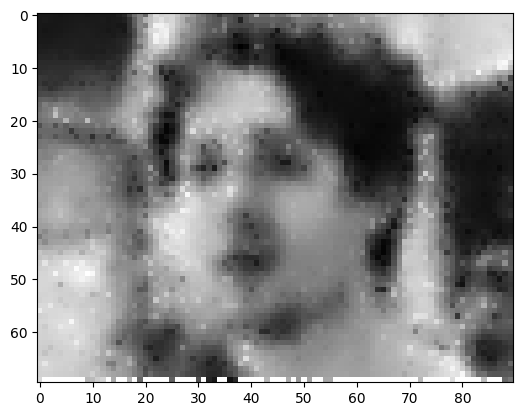

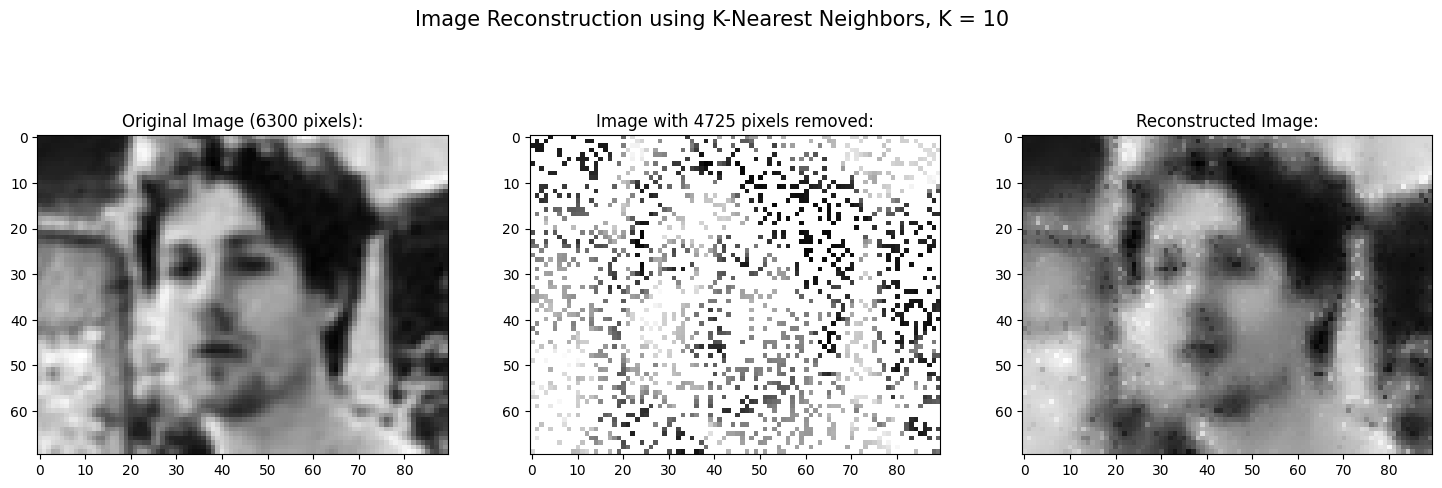

In [ ]:

'''
This is the only cell we need now.
'''


''' Imports: '''

import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
from google.colab.patches import cv2_imshow

'''
Site for resizing images (ideally to 100x100 px or less)
https://www.resizepixel.com
'''

# Default parameters:
file_name = 'SeanPhotoSmall.png'
k = 10
percent_to_remove = 75


def knn(filename = file_name, k = k, percent_to_remove = percent_to_remove):
    '''
    Function:       KNN
    Parameters:     filename            (string-- optional filename for local image you'd like to use)
                    K                   (integer-- the number of nearest neighbors we want to use)
                    percent_to_remove   (integer-- the percentage of pixels to knock out of the image for reconstruction)

    Returns:        Displays the original image, the image with pixels knocked out, and the reconstructed image created using the KNN algorithm.
    '''


    '''
    1. GET THE IMAGE:
    '''

    if filename == '':
        # No filename given.
        # Use Olivetti faces:

        from sklearn.datasets import fetch_olivetti_faces
        #from sklearn.utils.validation import check_random_state

        # Load the faces datasets
        data, targets = fetch_olivetti_faces(return_X_y=True)
        images = fetch_olivetti_faces().images

        # choose one image to test on:
        img1 = data[targets == 5][0]
        #print(img1.shape)

        image_shape = (64, 64)
        size = 64*64

        img0 = img1.copy()


        '''
        COPY OLIVETTI CODE FROM BELOW HERE

        need:

        img1
        img0
        image_shape
        size
        '''

    else:
        # Filename has been provided:
        ''' Read image with OpenCV: '''

        # Read image in with OpenCV:
        img = cv.imread(filename, 0)

        '''
        # Display the image:
        cv2_imshow(img)
        '''
        # Get image shape:
        image_shape = img.shape
        # Get image size:
        size = img.size
        # Resize image to 1-D array:
        img = img.reshape(size,).astype(float)
        # Create copies of image for use/manipulation later on:
        img1 = img.copy()
        img0 = img.copy()


    ''' Now have img0, img1, size, img_shape '''




    '''
    2. REMOVE PIXELS:
    '''

    # Removing a percentage of pixels from the image:

    # Get number of pixels to remove as a percentage of image size:
    num_to_remove = int(size * (int(percent_to_remove) / 100))

    # Create a set to store indices for pixels to remove:
    remove = set()
    # Add random indices until set has reached desired size:
    while len(remove) < num_to_remove:
        remove.add(np.random.randint(0, size-1))

    # Convert seet to list and remove all specified pixels:
    remove = np.array(list(remove))
    img1[remove] = np.nan

    # Print number of pixels removed:
    print("Number of pixels removed:", num_to_remove)

    # Display the image again (now with pixel(s) missing)
    plt.imshow(img1.reshape(image_shape), cmap=plt.cm.gray, interpolation="nearest")
    plt.show()

    # Save a copy of the 'noisy' image for later use:
    img_noise = img1.copy()




    '''
    3. RECONSTRUCT THE IMAGE:
    '''

    # START ACTUAL K-NN ALGORITHM HERE:



    '''
    K-NN ALGORITHM
    '''

    # Convert image to dataframe:
    df = pd.DataFrame(img1.copy().reshape(image_shape))
    new_df = df.copy()

    # Assign image size to a variable:
    img_size = img1.size
    # Get height, width:
    height, width = image_shape

    # Check that image isn't too large to process: (this number is kind of arbitrary)
    if img_size > 50000:
        print("Image too large. This will take way too long.")
        exit()

    # Iterate through every pixel by index
    # (using image size = total number of pixels)
    for i in range(img_size):

        # Get the row, column indices for the given pixel:
        current_row = i // width
        current_col = i % width
        # Access the value for the given pixel:
        current_pixel = df[current_col][current_row]

        # If current pixel is not NaN:
        if not math.isnan(current_pixel):
            continue
        else:
            ''' Pixel is NaN '''
            # Initialize an empty np array to store distances to all other pixels:
            distances = np.empty(img_size)
            # set all values to NaN:
            distances[:] = np.nan

            # Iterate through indices for all other pixels:
            for j in range(img_size):

                # Get the row, column indices for the given pixel:
                row = j // width
                col = j % width
                new_pixel = df[col][row]

                # if new pixel is NaN, skip it:
                if math.isnan(new_pixel):
                    continue
                # Checks if new pixel is the same as current pixel:
                # (I think this is unnecessary since if so, would be NaN)
                if (col == current_col) & (row == current_row):
                    continue

                # Calculate euclidean distance:
                h = col - current_col
                w = row - current_row
                h2 = h**2
                w2 = w**2
                sum = h2 + w2
                dist = np.sqrt(sum)
                # Assign distace to distances array:
                distances[j] = dist

            '''
            At this point, distances stores the distance to every other pixel from current_pixel,
            stored at the index of that pixel.
            '''

            # Get the indices of the k-smallest values (distances) in an array:
            k_smallest = np.argpartition(distances, k)[:k]

            # initialize empty array to store luminosity vals for nearest neighbors:
            lum_vals = np.zeros(len(k_smallest))
            # initialize empty array to store weight (inverted distance) vals for nearest neighbors:
            weights = np.zeros(len(k_smallest))

            # iterate through k smallest, for each access their luminosity, distance,
            for ind in range(len(k_smallest)):
                # Get the index for each neighbor:
                index = k_smallest[ind]
                # Get that neighbor's distance:
                distance = distances[index]
                row2 = index // width
                col2 = index % width
                # Get that neighbor's luminosity:
                luminosity = df[col2][row2]
                # Add luminosity to array of luminosity vals:
                lum_vals[ind] = luminosity
                # Add distance inverse to array of weight vals:
                weights[ind] = 1/distance

            # Get average (weighted) luminosity value:
            lum = np.average(a = lum_vals, weights = weights)
            # Assign new luminosity val to current pixel in new_df:
            new_df[current_col][current_row] = lum



            ''' NEW:'''
            import time
            from google.colab import output
            # DISPLAY THE IMAGE AS IT GETS FILLED:
            if i%width == (width-1):
                output.clear()
                plt.imshow(new_df, cmap=plt.cm.gray, interpolation = "nearest")
                plt.show()
                time.sleep(.3)
                #output.clear()





    # Display the reconstructed image:

    '''
    plt.imshow(new_df, cmap=plt.cm.gray, interpolation="nearest")
    plt.title("Reconstructed Image:")

    plt.show()
    '''

    '''

    Display the original, noisy, and reconstructed images side by side in one figure:

    '''

    figure, axis = plt.subplots(1, 3, figsize = (18, 6))

    # Display the original image:
    axis[0].imshow(img0.reshape(image_shape), cmap=plt.cm.gray, interpolation="nearest")
    axis[0].set_title("Original Image (" + str(img_size) + " pixels):")

    # Display the noisy image:
    axis[1].imshow(img_noise.reshape(image_shape), cmap=plt.cm.gray, interpolation="nearest")
    axis[1].set_title("Image with " + str(num_to_remove) + " pixels removed:")

    # Display the reconstructed image:
    axis[2].imshow(new_df, cmap=plt.cm.gray, interpolation="nearest")
    axis[2].set_title("Reconstructed Image:")

    # Add a margin between the main title and sub-plots
    figure.subplots_adjust(hspace=0.4, top=0.9)

    # Add the main title
    figure.suptitle("Image Reconstruction using K-Nearest Neighbors, K = " + str(k) , fontsize=15)

    plt.show()







'''
new_df is the dataframe which now stores the completed image.
df  was the dataframe used as reference (containing nans and original values)
'''

# Call the function:
knn(k=10, percent_to_remove = 75)

